In [15]:
import os
import sys
import shutil
import csv

if 'SUMO_HOME' in os.environ:
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import matplotlib.pyplot as plt
import pandas as pd
import traci

sys.path.append(os.path.abspath("../src"))
from sim import sumo_helper
from sim import sumo_simulation

FOLDER_NAME = "../src/sumo_map/town05" # Path to SUMO map folder

## Simulation Data

In [17]:
# ignore the first line (header) and read the rest as dictionaries
with open(f"{FOLDER_NAME}/routine_id_to_vtype.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    id_styles = {row['routine_id']: row['veh_style'] for row in reader}
    
id_styles
routine_ids = list(id_styles.keys())
veh_style_per_student = list(id_styles.values())

In [14]:
output_data_path = "../data/synthetic/sumo/config_a"
experiment2_file = 'merged.rou.xml' # The file that contains the routes for the experiment
delta_time = 0.01 # This delta time has to be the same as the one used in CARLA
end_time = 0 # 0 means no end time, the simulation will run until all vehicles finish their route

if os.path.exists(output_data_path):
    shutil.rmtree(output_data_path)
os.makedirs(output_data_path, exist_ok=True)

sumo_helper.add_xml_child(f'{FOLDER_NAME}/osm.sumocfg', 'input', 'route-files', f'{experiment2_file}', replace=True)

Child <route-files> with value 'merged.rou.xml' already exists. Skipping addition.


False

In [ ]:
try:
    veh_variables = sumo_simulation.get_all_variables(FOLDER_NAME, routine_ids, delta_time=delta_time, end_hours=end_time, use_gui=False, convert_geo=False, freeze_traffic_lights=True) # Running the simulation
    
except KeyboardInterrupt as e:
    traci.close() # Close the simulation if there is an error
    print(f"An error occurred: {e}")

 Retrying in 1 seconds
Child <step-length> already exists. Updating value to '0.01'.
XML file updated successfully.
Child <end> with value '' already exists. Skipping addition.
Vehicle veh0 has departed


Step #2105.20 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 201 ACT 0 BUF 0)                  


In [18]:
filesnames = {}
for i in range(len(routine_ids)):
    filesnames[routine_ids[i]] = f'{routine_ids[i]}_{veh_style_per_student[i].split("_")[-1]}'

sumo_simulation.save_data(veh_variables, output_data_path, delta_time, file_names=filesnames, new_dir=True, verify=True, use_lat_lon=False)

In [19]:
files = os.listdir(output_data_path)
df = pd.read_csv(f'{output_data_path}/{files[0]}')

In [20]:
def plot_df(df):
    fig, axs = plt.subplots(1, 3, figsize=(25, 5))

    # Plot acc_x
    axs[0].plot(df['timestamp'], df['acc_x'], label='acc_x')
    axs[0].set_title('Acceleration X over Time')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('acc_x (m/s²)')
    axs[0].legend()
    axs[0].grid(True)

    # Plot acc_y
    axs[1].plot(df['timestamp'], df['acc_y'], label='acc_y', color='orange')
    axs[1].set_title('Acceleration Y over Time')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('acc_y (m/s²)')
    axs[1].legend()
    axs[1].grid(True)
    
    # Plot x_pos vs y_pos, colored by time
    sc = axs[2].scatter(df['x_pos'], df['y_pos'], c=df['timestamp'], cmap='viridis', label='Trajectory')
    axs[2].set_title('Trajectory: x_pos vs y_pos (colored by time)')
    axs[2].set_xlabel('x_pos')
    axs[2].set_ylabel('y_pos')
    axs[2].legend()
    axs[2].grid(True)
    cbar = plt.colorbar(sc, ax=axs[2])
    cbar.set_label('Time (s)')

    plt.tight_layout()
    plt.show()

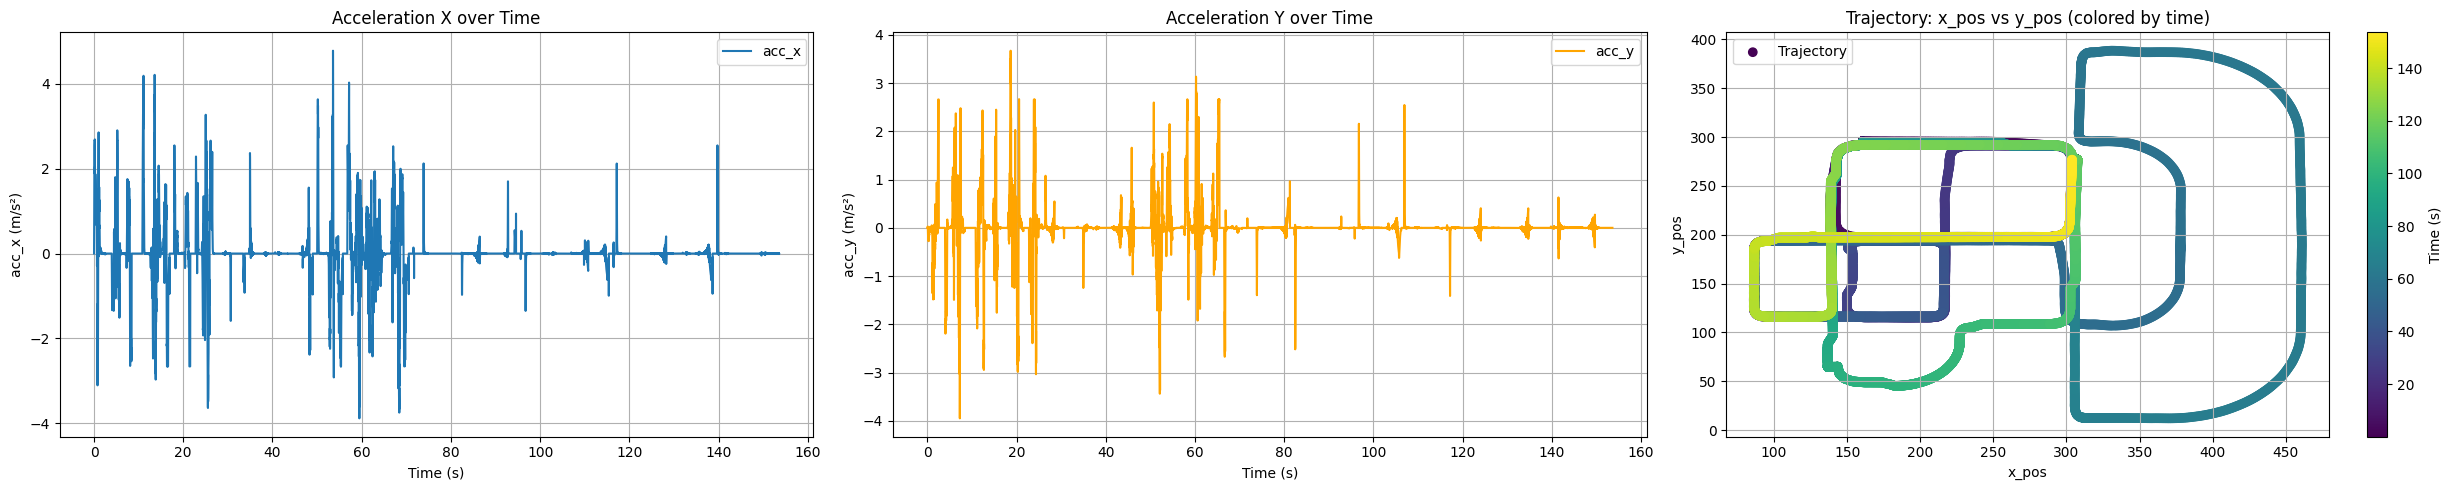

In [21]:
plot_df(df)